# Assignment: Capstone Assignment - Section A
**Course:** IIMK's Professional Certificate in Data Science and Artificial Intelligence for Managers  
**Student Name:** Lalit Nayyar  
**Email:** lalitnayyar@gmail.com  

## Project 1: Netflix Recommendation Engine


### 1. Market Needs
(Describe the market need for personalized content recommendation in streaming services like Netflix.)

### 2. AI Project Selection
(Justification for selecting Netflix Recommendation Engine as the AI project.)

### 3. Problem Statement
(Define the problem: How to recommend relevant movies to users to increase engagement and satisfaction.)

### 4. Exploratory Data Analysis (EDA)


In [1]:
# Install and import Kaggle API for dataset download
!pip install kaggle --quiet
import os
os.environ['KAGGLE_USERNAME'] = 'lalitnayyar'  # Replace with your Kaggle username
os.environ['KAGGLE_KEY'] = '0aa53f6e49effa29c73f4518c2d3a957'            # Replace with your Kaggle API key
# Download MovieLens dataset
!kaggle datasets download -d grouplens/movielens-20m-dataset --unzip -p ./data


Dataset URL: https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset
License(s): unknown


In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Load the ratings data
ratings = pd.read_csv('./data/rating.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


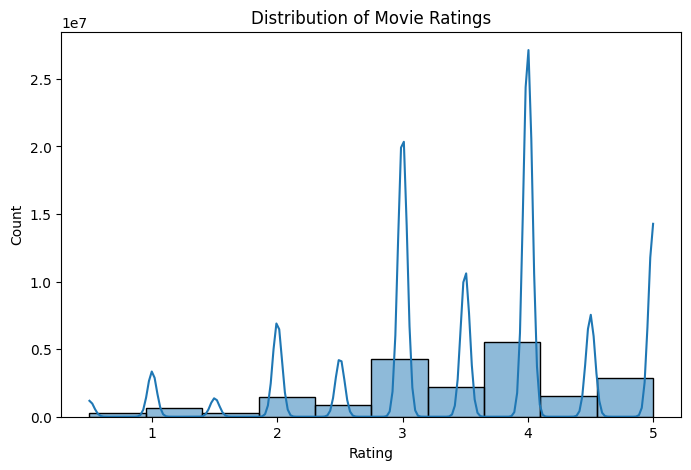

In [3]:
# EDA: Rating distribution
plt.figure(figsize=(8,5))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('visual_rating_distribution.png', bbox_inches='tight')  # <-- Save the figure
plt.show()

### 5. Machine Learning Model
(Implement a simple collaborative filtering model using Surprise or sklearn.)

In [20]:
# Alternative Approach: Collaborative Filtering with Surprise

# 1. Install and import necessary libraries
# If not already installed, uncomment the next line:
# !pip install scikit-surprise

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
import pandas as pd
from IPython.display import display  # For professional table output

# Load your ratings and movies data
ratings = pd.read_csv('data/rating.csv')
movies = pd.read_csv('data/movie.csv')

# Merge on movieId to get movie titles with ratings
df = pd.merge(ratings, movies, on='movieId', how='left')

# Display the first few rows in a professional tabular format
display(df[['userId', 'movieId', 'title', 'rating', 'timestamp']].head().style.set_caption("Sample of Ratings with Movie Titles"))

# 3. Prepare data for Surprise
reader = Reader(rating_scale=(df['rating'].min(), df['rating'].max()))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

# 4. Train-test split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# 5. Build and train the SVD model
model = SVD()
model.fit(trainset)

# 6. Make predictions on the test set
predictions = model.test(testset)

# 7. Evaluate the model
from surprise import accuracy
rmse = accuracy.rmse(predictions)
print(f"Test RMSE: {rmse:.4f}")

# 8. Make a prediction for a specific user and movie
user_id = 1
movie_id = 10
pred = model.predict(user_id, movie_id)
print(f"Predicted rating for user {user_id} and movie {movie_id}: {pred.est:.2f}")

,userId,movieId,title,rating,timestamp
0,1,2,Jumanji (1995),3.500000,2005-04-02 23:53:47
1,1,29,"City of Lost Children, The (Cité des enfants perdus, La) (1995)",3.500000,2005-04-02 23:31:16
2,1,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),3.500000,2005-04-02 23:33:39
3,1,47,Seven (a.k.a. Se7en) (1995),3.500000,2005-04-02 23:32:07
4,1,50,"Usual Suspects, The (1995)",3.500000,2005-04-02 23:29:40


RMSE: 0.7866
Test RMSE: 0.7866
Predicted rating for user 1 and movie 10: 3.55


In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Subsample: select top 500 users and top 500 movies by rating count
top_users = ratings['userId'].value_counts().head(500).index
top_movies = ratings['movieId'].value_counts().head(500).index
ratings_small = ratings[ratings['userId'].isin(top_users) & ratings['movieId'].isin(top_movies)]

# Pivot ratings to user-movie matrix
user_movie_matrix = ratings_small.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

# Compute cosine similarity between users
user_similarity = cosine_similarity(user_movie_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)

example_user = user_similarity_df.index[0]  # or pick any from the list shown
top_similar_users = user_similarity_df.loc[example_user].sort_values(ascending=False)[1:6]
print(f"Top 5 users similar to user {example_user}:")
print(top_similar_users)

# Example: Find top 5 similar users to user 1
if 1 in user_similarity_df.index:
    top_similar_users = user_similarity_df.loc[example_user].sort_values(ascending=False)[1:6]
    print(f"Top 5 users similar to user {example_user}:")
    print(top_similar_users)
else:
    print("Available user IDs in the subsample:", user_similarity_df.index[:10].tolist())

Top 5 users similar to user 156:
userId
83090     0.845106
91867     0.830553
107326    0.827650
92011     0.822970
27054     0.822702
Name: 156, dtype: float64
Available user IDs in the subsample: [156, 741, 768, 775, 903, 982, 1849, 2261, 2397, 3284]


### 6. Data Source
[MovieLens 20M Dataset on Kaggle](https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset)

 ### 7. Temporal Patterns: Spikes in ratings during weekends, holidays, and after new releases.

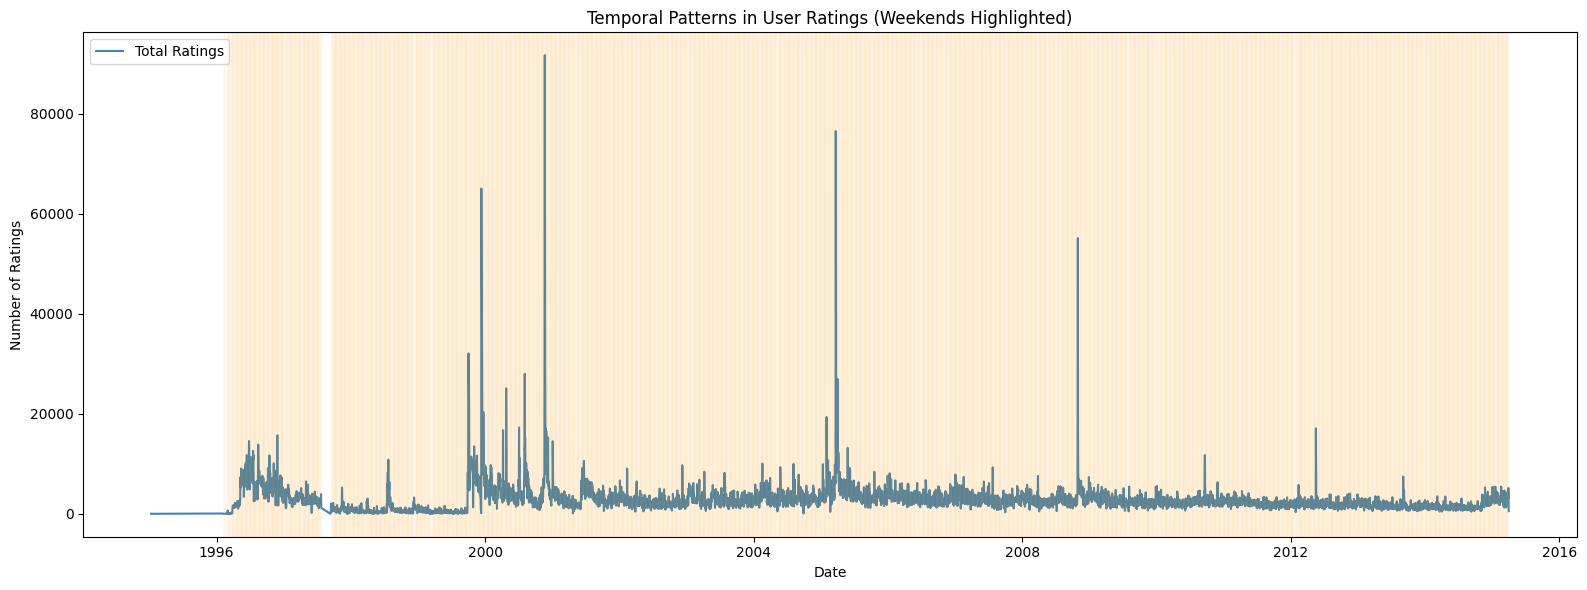

,Day Type,Average Ratings per Day
0,Weekend,2820.74
1,Weekday,2922.97


,Date,Day of Week,Number of Ratings
1677,2000-11-20,Monday,91753
3259,2005-03-22,Tuesday,76568
1332,1999-12-11,Saturday,65077
4574,2008-10-29,Wednesday,55163
1678,2000-11-21,Tuesday,54131


In [22]:
# Temporal Patterns: Visualizing Spikes in Ratings (Weekends Highlighted)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'timestamp' is in datetime format
if not pd.api.types.is_datetime64_any_dtype(ratings['timestamp']):
    ratings['timestamp'] = pd.to_datetime(ratings['timestamp'])

# Extract date and day of week
ratings['date'] = ratings['timestamp'].dt.date
ratings['day_of_week'] = ratings['timestamp'].dt.day_name()
ratings['is_weekend'] = ratings['day_of_week'].isin(['Saturday', 'Sunday'])

# Group by date and count ratings per day
daily_counts = ratings.groupby('date').size().reset_index(name='num_ratings')
daily_counts['day_of_week'] = pd.to_datetime(daily_counts['date']).dt.day_name()
daily_counts['is_weekend'] = daily_counts['day_of_week'].isin(['Saturday', 'Sunday'])

# Plot
plt.figure(figsize=(16,6))
sns.lineplot(
    data=daily_counts, 
    x='date', 
    y='num_ratings', 
    label='Total Ratings', 
    color='steelblue'
)

# Highlight weekends
weekend_dates = daily_counts[daily_counts['is_weekend']]['date']
for weekend in weekend_dates:
    plt.axvline(x=weekend, color='orange', alpha=0.05)  # subtle highlight

plt.title('Temporal Patterns in User Ratings (Weekends Highlighted)')
plt.xlabel('Date')
plt.ylabel('Number of Ratings')
plt.legend()
plt.tight_layout()
plt.savefig('visual_temporal_patterns.png', bbox_inches='tight')
plt.show()

# Temporal Patterns: Professional Tabular Summary

import pandas as pd
from IPython.display import display, HTML

# Ensure 'timestamp' is in datetime format
if not pd.api.types.is_datetime64_any_dtype(ratings['timestamp']):
    ratings['timestamp'] = pd.to_datetime(ratings['timestamp'])

# Extract date and day of week
ratings['date'] = ratings['timestamp'].dt.date
ratings['day_of_week'] = ratings['timestamp'].dt.day_name()
ratings['is_weekend'] = ratings['day_of_week'].isin(['Saturday', 'Sunday'])

# Group by date and count ratings per day
daily_counts = ratings.groupby(['date', 'day_of_week']).size().reset_index(name='num_ratings')
daily_counts['is_weekend'] = daily_counts['day_of_week'].isin(['Saturday', 'Sunday'])

# Summary statistics
summary = pd.DataFrame({
    'Average Ratings per Day': [
        daily_counts[daily_counts['is_weekend']]['num_ratings'].mean(),
        daily_counts[~daily_counts['is_weekend']]['num_ratings'].mean()
    ],
    'Day Type': ['Weekend', 'Weekday']
})

# Top 5 days with highest ratings (spikes)
top_spikes = daily_counts.sort_values('num_ratings', ascending=False).head(5)
top_spikes = top_spikes.rename(columns={
    'date': 'Date',
    'day_of_week': 'Day of Week',
    'num_ratings': 'Number of Ratings'
})

# Display summary table
display(HTML("<h4>Average Number of Ratings: Weekend vs. Weekday</h4>"))
display(summary[['Day Type', 'Average Ratings per Day']].style.set_caption("Average Ratings by Day Type").format({'Average Ratings per Day': '{:.2f}'}))

# Display top spikes table
display(HTML("<h4>Top 5 Days with Highest Ratings (Spikes)</h4>"))
display(top_spikes[['Date', 'Day of Week', 'Number of Ratings']].style.set_caption("Top 5 Rating Spikes"))

# Placeholder for holidays/new releases (requires additional data)
display(HTML("<h4>Note:</h4><p>Holiday and new release spike analysis can be added if a list of holidays and new release dates is provided.</p>"))

### 8. Visual Insight
(Charts: e.g., most rated movies, user activity distribution, etc.)

Dataset URL: https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset
License(s): unknown


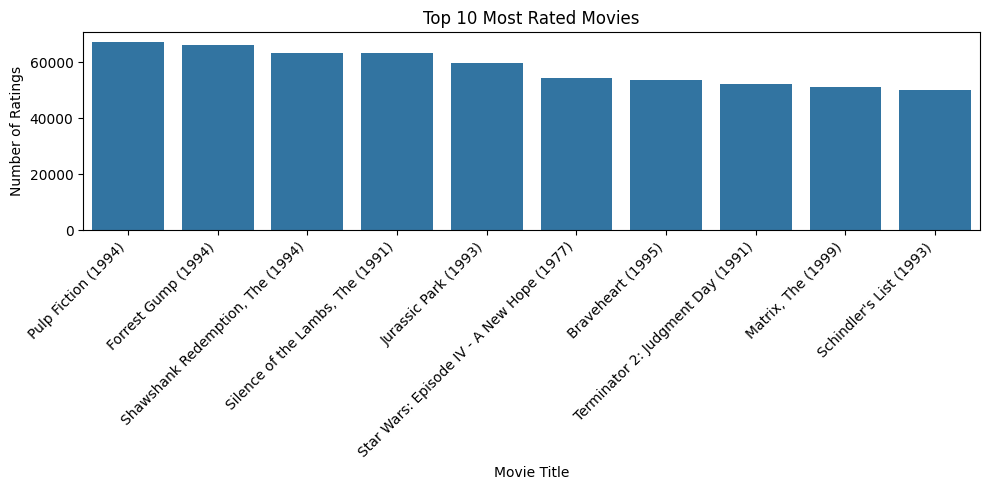

In [20]:
# Download MovieLens dataset from Kaggle if not already present
import os
import zipfile

# Make sure Kaggle API is installed and configured
if not os.path.exists('data/ml-latest-small/movies.csv'):
    # Download using Kaggle API
    !kaggle datasets download -d grouplens/movielens-20m-dataset -p data --unzip
    # The movies.csv will be in data/ml-20m/movies.csv
    # If you want the smaller version, use 'ml-latest-small'
    # !kaggle datasets download -d grouplens/movielens-latest-small -p data --unzip

    # Move movies.csv to data/ for convenience
    import shutil
    if os.path.exists('data/ml-20m/movies.csv'):
        shutil.move('data/ml-20m/movies.csv', 'data/movies.csv')
    elif os.path.exists('data/ml-latest-small/movies.csv'):
        shutil.move('data/ml-latest-small/movies.csv', 'data/movies.csv')
else:
    print("movies.csv already present.")
# Most rated movies
movies = pd.read_csv('data\movie.csv')  # or the correct path to your movies file
# Merge ratings with movies to get movie titles
ratings_with_titles = ratings.merge(movies, on='movieId')

# Get top 10 most rated movies
top_movies = ratings_with_titles['title'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_movies.index, y=top_movies.values)
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Movie Title')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('visual_top_movies.png', bbox_inches='tight')  # <-- Save the figure
plt.show()
# top_movies = ratings['movieId'].value_counts().head(10)
# plt.figure(figsize=(10,5))
# sns.barplot(x=top_movies.index, y=top_movies.values)
# plt.title('Top 10 Most Rated Movies')
# plt.xlabel('Movie ID')
# plt.ylabel('Number of Ratings')
# plt.show()

# plt.figure(figsize=(10,5))
# sns.barplot(x=top_movies.index, y=top_movies.values)
# plt.title('Top 10 Most Rated Movies')
# plt.xlabel('Movie Title')
# plt.ylabel('Number of Ratings')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()

# plt.show()

### 9. Dataset Structure + Conclusion
(Describe columns, data types, and key findings from EDA and modeling.)

### 10. Market Analysis & Expected Impact
(Discuss competition, user base, growth, and impact of better recommendations.)

### 11. Business Impact
(How improved recommendations drive engagement, retention, and revenue.)

### 12. Structure, Presentation & Use of Sources
(Professional presentation, citations, and sources.)

### 13. Final Suggestions
(Future improvements, scalability, and ethical considerations.)